In [412]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [425]:
#Define system of ODEs
def dGas(C, t, F_vap, FGF, MV, lambdas):
    
    TBW = 70 # Body weight in kg
    FRC = 4 # FRC in L
    V_B = 0.07*TBW #Blood comparmtent volume
    V_art = 0.3 * V_B # Fraction of blood in arterial compartment
    V_ven = 0.7 * V_B # Fraction of blood in venous compartment
    V_F = 0.2*TBW/0.9 #Fat compartment volume (15% bodyweight, density 0.9 g/cc)
    V_VRG = 0.3 * TBW #VRG volume
    V_musc = 0.5 * TBW #Muscle compartment volume
    V_circuit = 6 #Volume of anesthesia circuit/tubing
    
    #Fraction of cardiac output delivered to various tissues
    f_F = 0.1
    f_musc = 0.3
    f_VRG = 0.6

    CO = 5 #cardiac output L/min
    
    #Unpack partition coefficients
    lambda_bg, lambda_fb, lambda_mb, lambda_vrg = lambdas
    
    #Unpack concentrations in various compartments
    C_alv, C_art, C_fat, C_musc, C_VRG, C_ven, C_circ = C

    
    #Differential transfer of drug between compartments
    dM_alv = MV*(C_circ-C_alv) - CO*(C_alv-C_ven/lambda_bg)
    dM_art = CO*((C_alv - C_ven/(lambda_bg)) + C_ven - C_art)
    dM_fat = f_F*CO*(C_art-C_fat/(lambda_fb))
    dM_musc = f_musc*CO*(C_art-C_musc/(lambda_mb))
    dM_VRG = f_VRG*CO*(C_art-C_VRG/(lambda_vrg))
    dM_ven = CO*C_art - dM_fat - dM_musc - dM_VRG - CO*C_ven
    dM_circuit = FGF*(F_vap-C_circ) + MV*(C_alv-C_circ)
    
    return [dM_alv/FRC, dM_art/V_art, dM_fat/V_F, dM_musc/V_musc, dM_VRG/V_VRG, dM_ven/V_ven, dM_circuit/V_circuit]



Simple example using properties of isoflurane

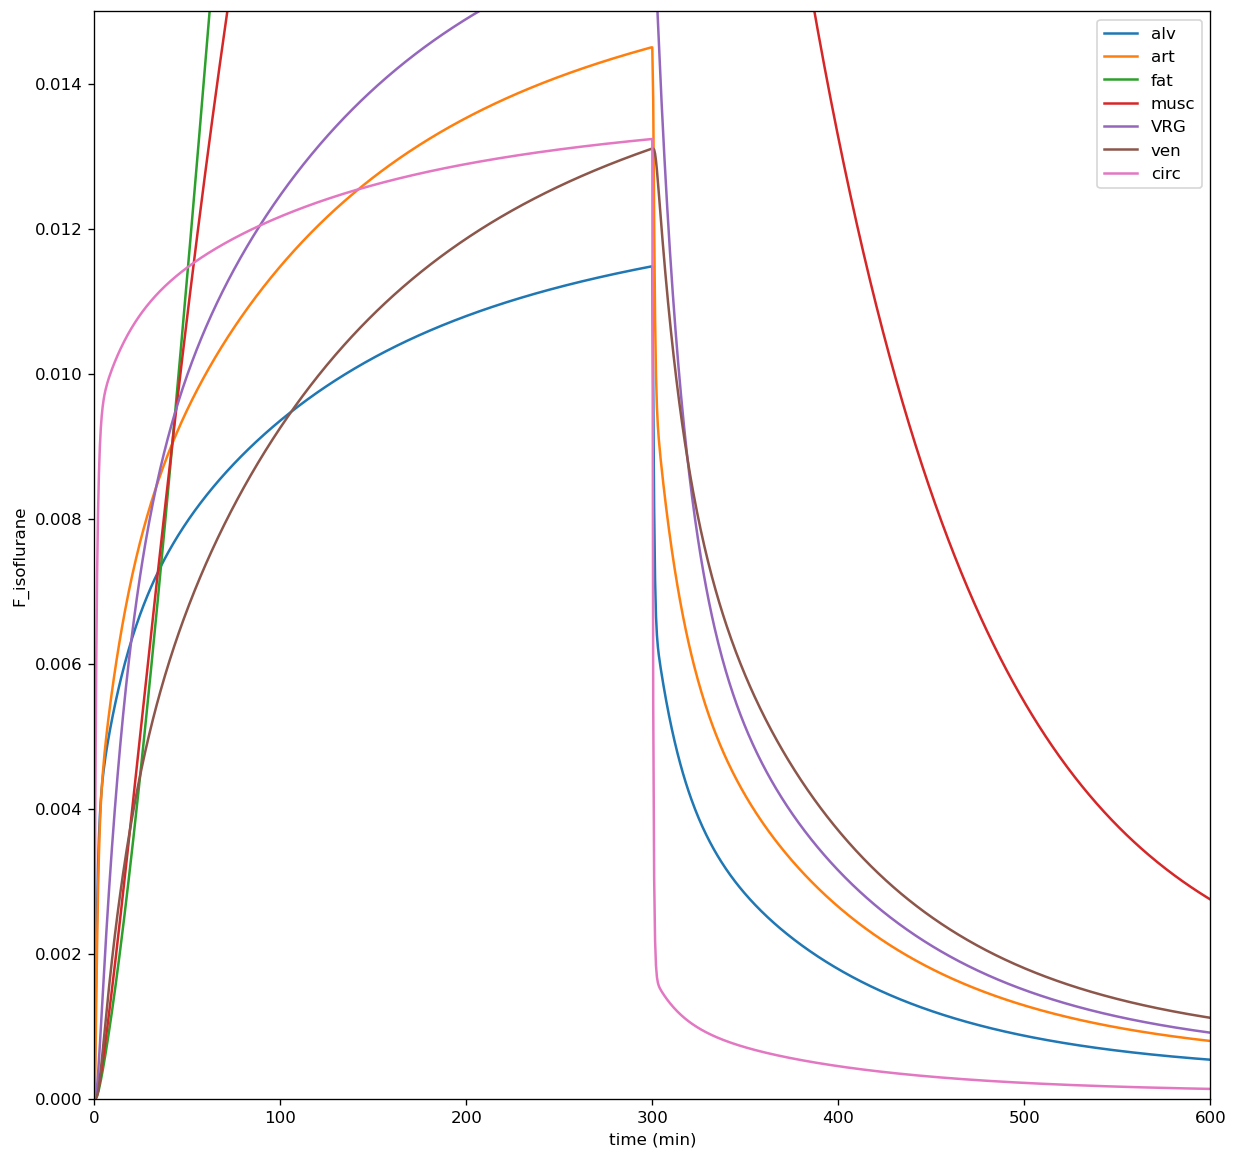

In [449]:

#Partition coefficients for isoflurane
lambda_bg = 1.3
lambda_fb = 36
lambda_mb = 2.37
lambda_vrg = 1.11

lambdas_iso = [lambda_bg, lambda_fb, lambda_mb, lambda_vrg]


# Array of changes in format of [time, F_vap (i.e. vaporizer dial position), fresh gas flow, minute ventilation,]
changes = np.array([[0, 0.015, 4, 4],
                    [300, 0, 12, 4]
                   ])


C0 = [0, 0, 0, 0, 0, 0, 0] #Initialize compartment with concentration = 0
sol = np.array([C0])
times = np.array([0])


#Loop through changes, taking final concentrations in compartments as initial conditions for next integration
for index, change in enumerate(changes, 1):
    time, F_vap, FGF, MV = change
    try:
        t = np.arange(time,changes[index][0],0.5)
    except:
        t = np.arange(time,time+720,0.5) # After last change, continue integration for 12 hours
    
    current = odeint(dGas, C0, t, args=(F_vap, FGF, MV, lambdas_iso))
    sol = np.concatenate((sol, current), axis=0)
    times = np.concatenate((times, t), axis=0)
    C0 = current[-1]

fig=plt.figure(figsize=(12, 12), dpi= 120, facecolor='w', edgecolor='k')
plt.plot(times, sol)
plt.ylabel('F_isoflurane')
plt.xlabel('time (min)')
plt.xlim(0,600)
plt.ylim(0, 0.015)
plt.legend(['alv', 'art', 'fat', 'musc', 'VRG', 'ven', 'circ'])



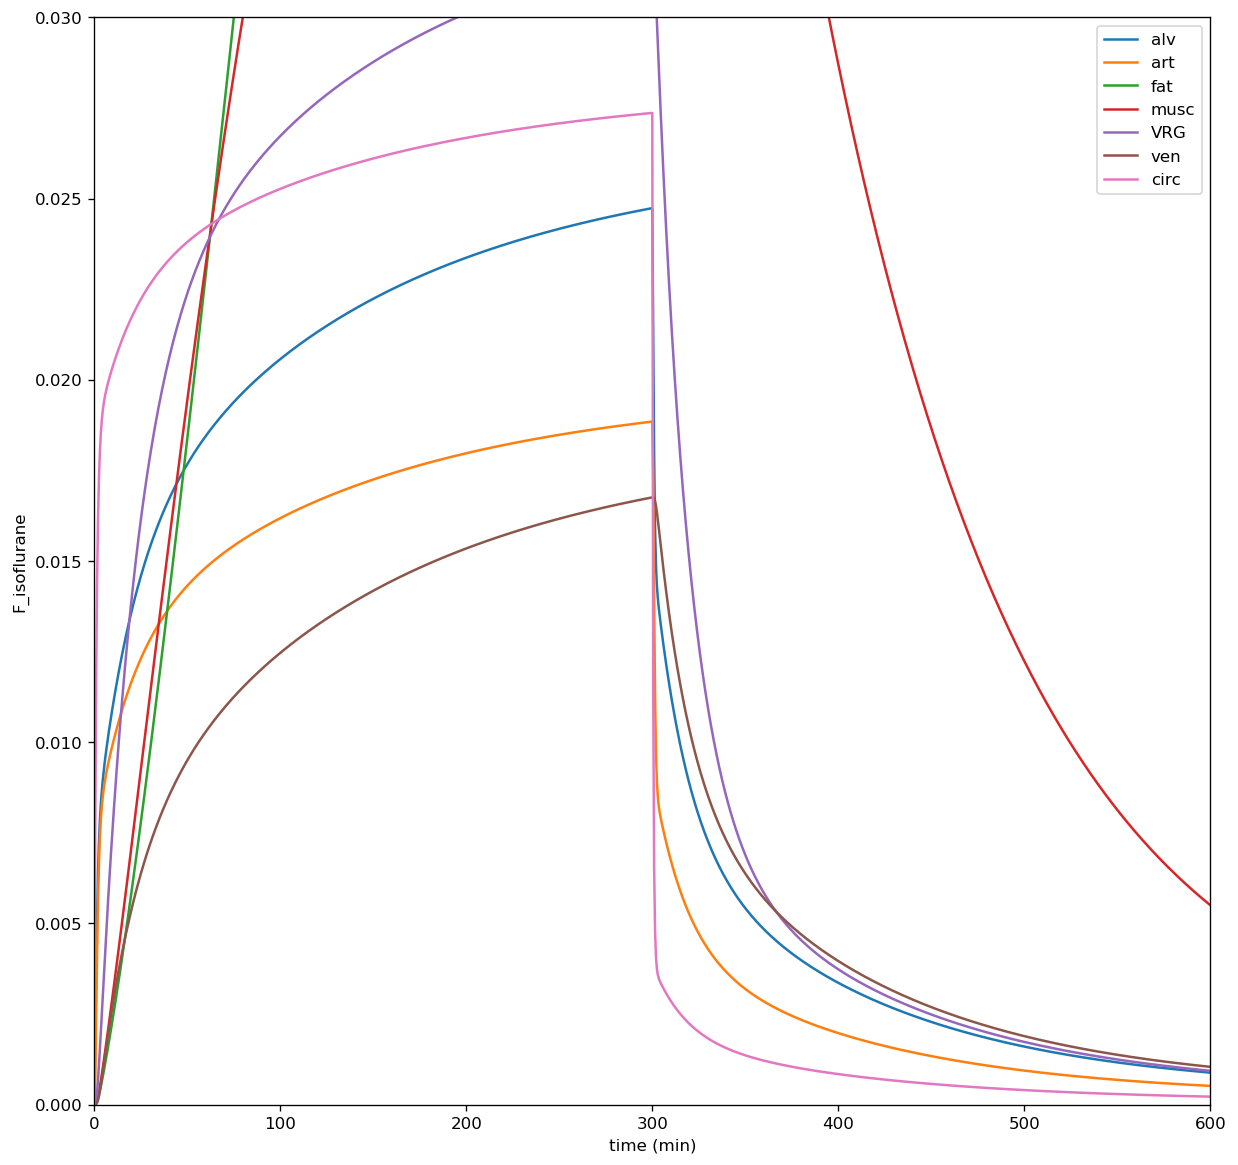

In [446]:
#Partition coefficients for sevoflurane
lambda_bg = 0.74
lambda_fb = 53
lambda_mb = 3.69
lambda_vrg = 1.69

lambdas_sevo = [lambda_bg, lambda_fb, lambda_mb, lambda_vrg]


# Array of changes in format of [time, F_vap (i.e. vaporizer dial position), fresh gas flow, minute ventilation,]
changes = np.array([[0, 0.03, 4, 4], 
                    [300, 0, 12, 4]
                   ])


C0 = [0, 0, 0, 0, 0, 0, 0] #Initialize compartment with concentration = 0
sol = np.array([C0])
times = np.array([0])


#Loop through changes, taking final concentrations in compartments as initial conditions for next integration
for index, change in enumerate(changes, 1):
    time, F_vap, FGF, MV = change
    try:
        t = np.arange(time,changes[index][0],0.5)
    except:
        t = np.arange(time,time+720,0.5) # After last change, continue integration for 12 hours
    
    current = odeint(dGas, C0, t, args=(F_vap, FGF, MV, lambdas_sevo))
    sol = np.concatenate((sol, current), axis=0)
    times = np.concatenate((times, t), axis=0)
    C0 = current[-1]

fig=plt.figure(figsize=(12, 12), dpi= 120, facecolor='w', edgecolor='k')
plt.plot(times, sol)
plt.ylabel('F_isoflurane')
plt.xlabel('time (min)')
plt.xlim(0,600)
plt.ylim(0, 0.03)
plt.legend(['alv', 'art', 'fat', 'musc', 'VRG', 'ven', 'circ'])

## Switching between volatiles
Suppose 2 volatile agents with identical partition coefficients to sevoflurane (called sevo1 and sevo2). Now solve for the effective MAC over time for three conditions: Switching from sevo1 to sevo2 half way through 600 minutes of use vs. running sevo (could be sevo1 or sevo2) for 600 minutes continuously).

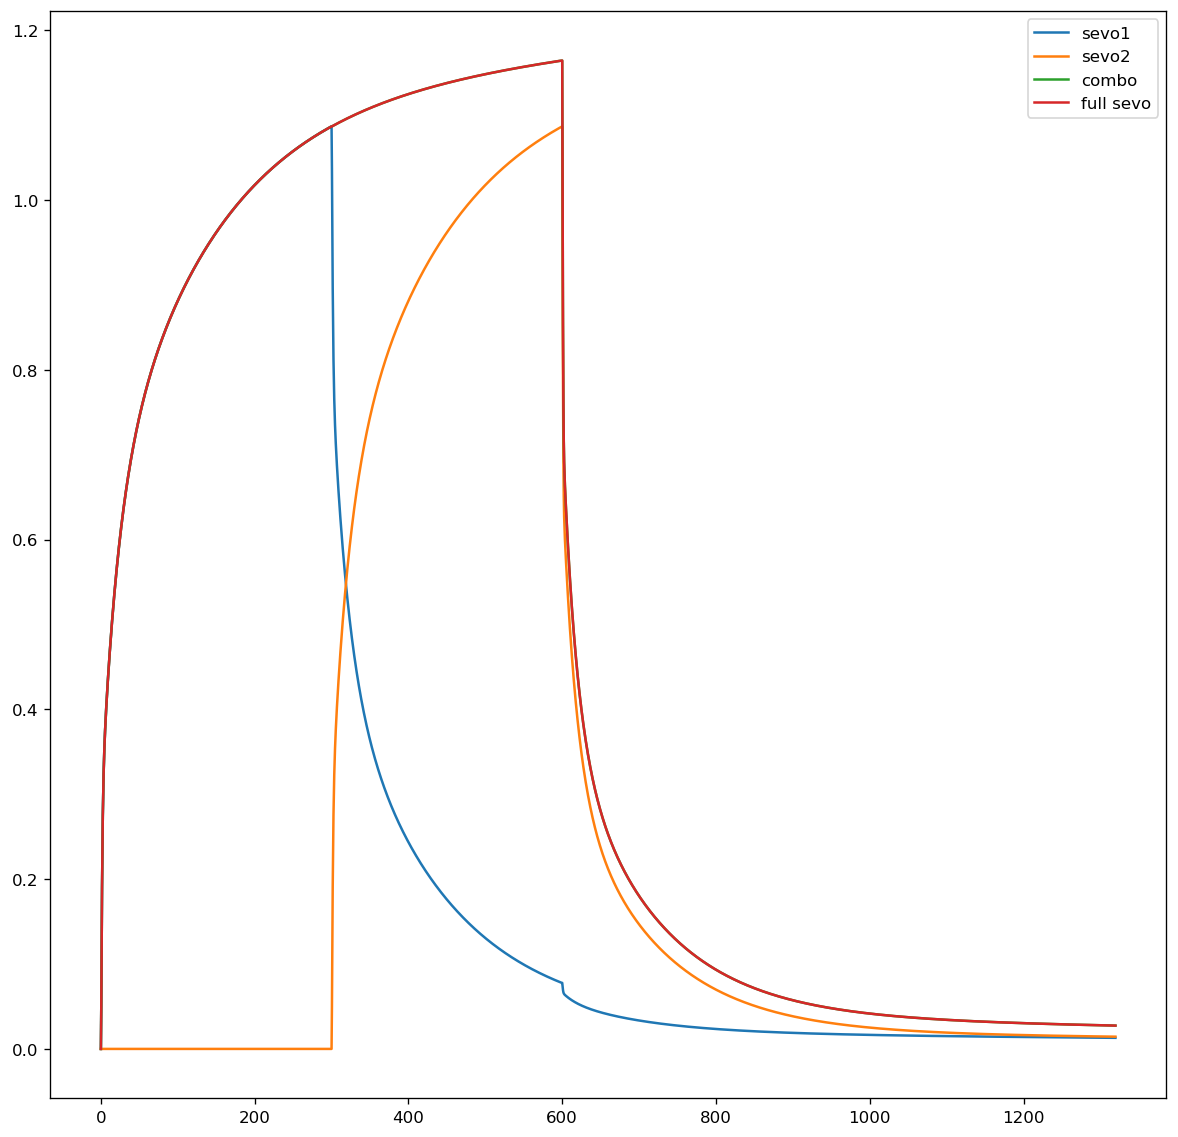

In [457]:
def integrateSevo(changes, lambdas):
    
    C0 = [0, 0, 0, 0, 0, 0, 0] #Initialize compartment with concentration = 0
    sol = np.array([C0])
    times = np.array([0])


    #Loop through changes, taking final concentrations in compartments as initial conditions for next integration
    for index, change in enumerate(changes, 1):
        time, F_vap, FGF, MV = change
        try:
            t = np.arange(time,changes[index][0],0.5)
        except:
            t = np.arange(time,time+720,0.5) # After last change, continue integration for 12 hours

        current = odeint(dGas, C0, t, args=(F_vap, FGF, MV, lambdas))
        sol = np.concatenate((sol, current), axis=0)
        times = np.concatenate((times, t), axis=0)
        C0 = current[-1]
    
    return [times, sol]


#Solution for Sevo1:
changes = np.array([[0, 0.03, 3, 4], 
                    [300, 0, 3, 4],
                    [600, 0, 12, 4]
                   ])


times, solSevo1 = integrateSevo(changes, lambdas_sevo)




#Solution for sevo2
changes = np.array([[0, 0.0, 3, 4], 
                    [300, 0.03, 3, 4],
                    [600, 0, 12, 4]
                   ])


times, solSevo2 = integrateSevo(changes, lambdas_sevo)




#Solution for continuous sevoflurane
changes = np.array([[0, 0.03, 3, 4], 
                    [300, 0.03, 3, 4],
                    [600, 0, 12, 4]
                   ])


times, solSevoFull = integrateSevo(changes, lambdas_sevo)




# Plot the alveolar fraction (normalized to 1 MAC=0.022) for both effects of sevo1 and 2 seperately and combined, and for sevo conditions:

fig = plt.figure(figsize=(12, 12), dpi=120, facecolor='w', edgecolor='k')
plt.plot(times, solSevo1[:,0]/0.022)
plt.plot(times, solSevo2[:,0]/0.022)
plt.plot(times, solSevo1[:,0]/0.022+solSevo2[:,0]/0.022)
plt.plot(times, solSevo[:,0]/0.022)


plt.legend(['sevo1', 'sevo2', 'combo', 'full sevo'])